## **CNN para classificação multiclasse de imagens**
**Dataset MNIST (Modified National Institute of Standards and Technology)**
- É considerado o dataset “hello world” de *computer vision*.
- Dataset de imagens de dígitos escritos manualmente
- Inputs: imagens de 28x28 pixeis
- Output: classe a representar o dígito (10 classes, dígitos 0-9)
- 70k imagens das quais 60k são para treino e 10k para teste
- 2 atributos: o id da imagem e o respetivo label   

Vamos utilizar uma rede neuronal para classificação do dígito em cada imagem de 28x28.

## imports

In [71]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

import os
from livelossplot import PlotLosses

np.random.seed(0)
torch.manual_seed(0)
import random

random.seed(0)

torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(0)

torch.use_deterministic_algorithms(False)

In [72]:
PATH = './'
PATH_TRAIN = '../AP_Aula3_PL_datasets/mnist_train.csv'
PATH_TEST = '../AP_Aula3_PL_datasets/mnist_test.csv'

BATCH_SIZE = 32

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados

In [74]:
train_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])
test_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])

In [75]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform

        df_set = pd.read_csv(path, header=0)

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train,transform=train_transform)
    dataset_test = CSVDataset(path_test,transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [76]:
def output_label(label,mapping='label'):
    if mapping == 'ext':
        output_mapping = { 0:"zero", 1:"um", 2:"dois", 3:"tres", 4:"quatro", 5:"cinco", 6:"seis", 7:"sete", 8:"oito", 9:"nove" }
    elif mapping == 'ext2':
        output_mapping = { "0":"zero", "1":"um", "2":"dois", "3":"tres", "4":"quatro", "5":"cinco", "6":"seis", "7":"sete", "8":"oito", "9":"nove" }
    else:
        output_mapping = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [77]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(f'Valor máximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor máximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)
    
visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:47999
Quantidade de casos de Validação:12000
Quantidade de casos de Teste:9999
Shape tensor batch casos treino, input: torch.Size([32, 1, 28, 28]), output: torch.Size([32])
Shape tensor batch casos validação, input: torch.Size([32, 1, 28, 28]), output: torch.Size([32])
Shape tensor batch casos test, input: torch.Size([32, 1, 28, 28]), output: torch.Size([32])
Valor máximo:1.0 Valor mínimo:0.0
Valor máximo:1.0 Valor mínimo:0.0
tensor([4, 3, 1, 2, 3, 3, 7, 1, 5, 0, 7, 7, 2, 9, 7, 2, 2, 4, 3, 4, 8, 5, 4, 1,
        3, 2, 9, 6, 1, 0, 0, 8])


torch.Size([32, 1, 28, 28])


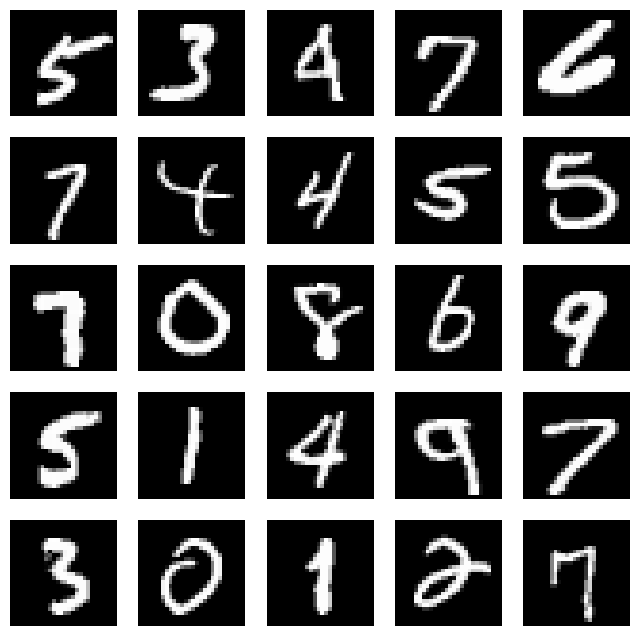

In [78]:
def visualize_mnist_images(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid()
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()

visualize_mnist_images(train_dl)

## 1.2 Verificar balanceamento do dataset

-----------------------------------casos_treino-----------------------------------
casos: 47999
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[4745 5399 4759 4861 4693 4340 4783 4960 4702 4757]
47999


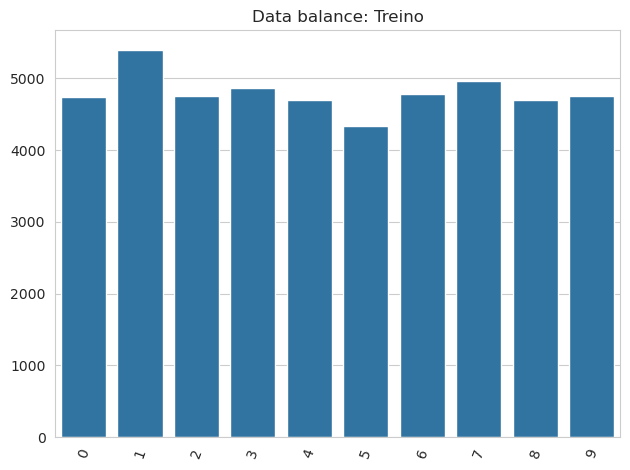

-----------------------------------casos_validação-----------------------------------
casos: 12000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[1178 1343 1199 1270 1149 1080 1135 1305 1149 1192]
12000


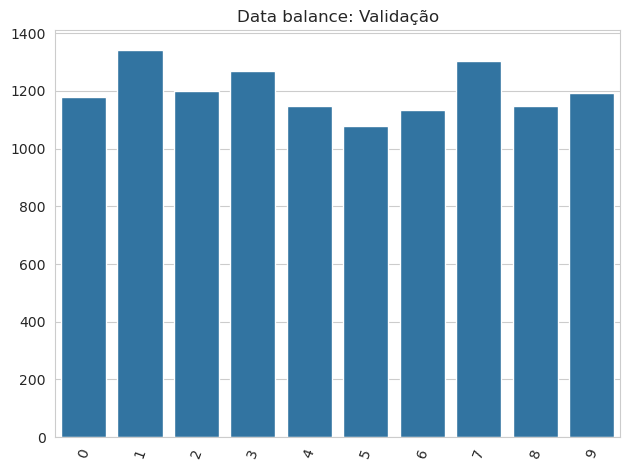

-----------------------------------casos_teste-----------------------------------
casos: 9999
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[ 980 1135 1032 1010  982  892  958 1027  974 1009]
9999


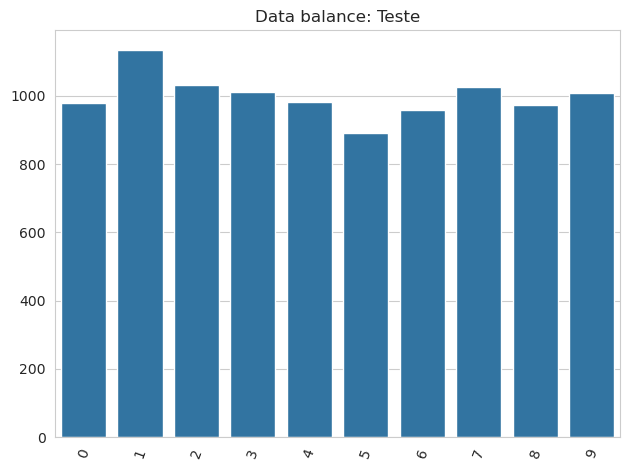

In [79]:
import seaborn as sns
def visualize_holdout_balance(dl, titulo):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[output_label(n,'ext') for n in x]
    print([output_label(n)  for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance(train_dl_all, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance(val_dl_all, 'Validação')
print("-----------------------------------casos_teste-----------------------------------") 
visualize_holdout_balance(test_dl_all, 'Teste')

## 2. Definir o Modelo

In [80]:
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=5*5*32, out_features=100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10)
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 5*5*32)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out

model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 32, 26, 26]          320
│    └─ReLU: 2-2                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 32, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          9,248
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 100]                 80,100
├─ReLU: 1-4                              [32, 100]                 --
├─Linear: 1-5                            [32, 10]                  1,010
├─Softmax: 1-6                           [32, 10]                  --
Tota

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

In [81]:
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )       
        self.fc1 = Linear(32 * 5 * 5, 10)  
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        return out
    
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 16, 26, 26]          160
│    └─ReLU: 2-2                         [32, 16, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 16, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          4,640
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 10]                  8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
Total mult-adds (M): 21.68
Input size (MB): 0.10
Forward/backward pass size (MB): 3.76
Params size (MB): 0.05
Estimated Total Size (MB): 3.91


CNNModel_2(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)

In [82]:
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 28, 28]          64
│    └─ReLU: 2-3                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
├─Sequential: 1-2                        [32, 64, 6, 6]            --
│    └─Conv2d: 2-5                       [32, 64, 12, 12]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 12, 12]          128
│    └─ReLU: 2-7                         [32, 64, 12, 12]          --
│    └─MaxPool2d: 2-8                    [32, 64, 6, 6]            --
├─Linear: 1-3                            [32, 600]                 1,383,000
├─Dropout2d: 1-4                         [32, 600]                 --
├─

/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CNNModel_3(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [83]:
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(2),
                                    Dropout2d(0.2)
                                    )
        self.fc1 = Linear(in_features=32*12*12, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 32, 24, 24]          832
│    └─BatchNorm2d: 2-2                  [32, 32, 24, 24]          64
│    └─ReLU: 2-3                         [32, 32, 24, 24]          --
│    └─MaxPool2d: 2-4                    [32, 32, 12, 12]          --
│    └─Dropout2d: 2-5                    [32, 32, 12, 12]          --
├─Linear: 1-2                            [32, 128]                 589,952
├─Linear: 1-3                            [32, 10]                  1,290
Total params: 592,138
Trainable params: 592,138
Non-trainable params: 0
Total mult-adds (M): 34.26
Input size (MB): 0.10
Forward/backward pass size (MB): 9.47
Params size (MB): 2.37
Estimated Total Size (MB): 11.94


CNNModel_4(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## 3. Treinar o Modelo

In [84]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file)

In [85]:
######### CNNModel_1 ################
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 32, 26, 26]          320
│    └─ReLU: 2-2                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 32, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          9,248
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 100]                 80,100
├─ReLU: 1-4                              [32, 100]                 --
├─Linear: 1-5                            [32, 10]                  1,010
├─Softmax: 1-6                           [32, 10]                  --
Tota

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

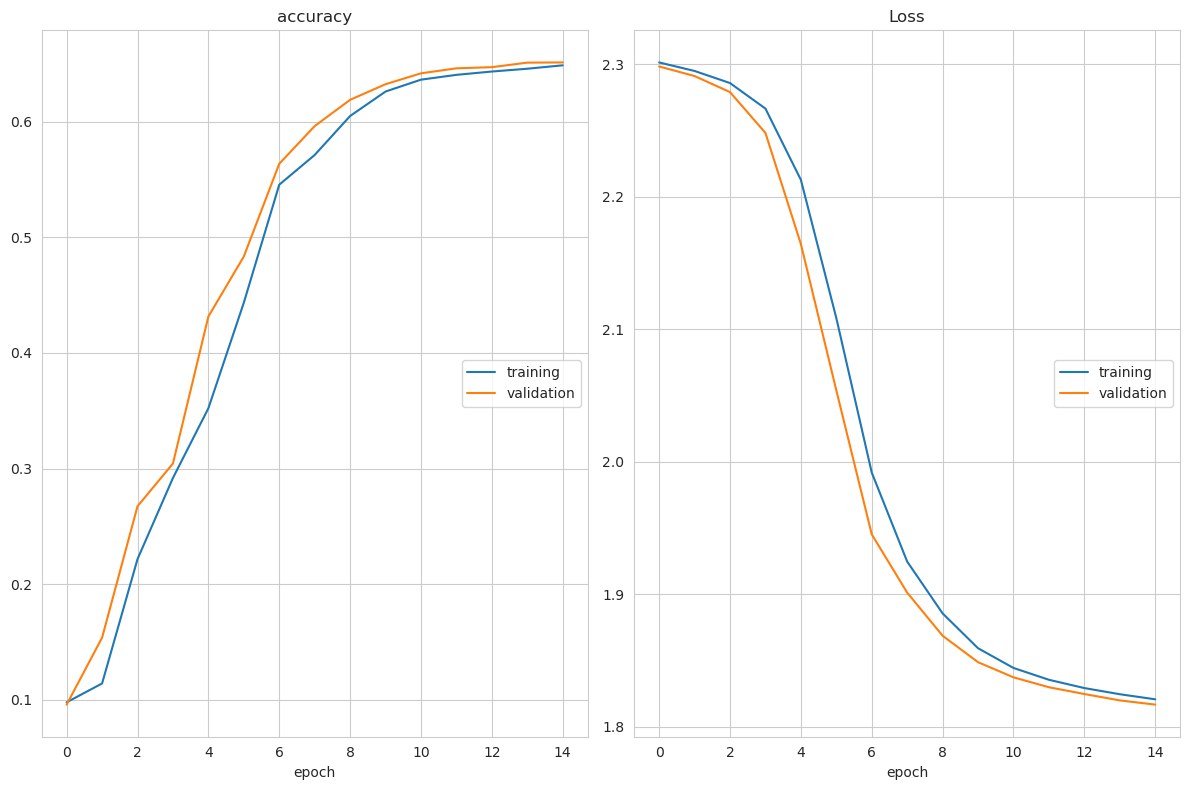

accuracy
	training         	 (min:    0.098, max:    0.649, cur:    0.649)
	validation       	 (min:    0.096, max:    0.651, cur:    0.651)
Loss
	training         	 (min:    1.821, max:    2.301, cur:    1.821)
	validation       	 (min:    1.817, max:    2.298, cur:    1.817)
Tempo gasto: 59.11430719500004 segundos


In [86]:
EPOCHS = 15
LEARNING_RATE = 0.001

criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [87]:
######### CNNModel_2 ################
model = CNNModel_2()
model.to(device)
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 16, 26, 26]          160
│    └─ReLU: 2-2                         [32, 16, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 16, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          4,640
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 10]                  8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
Total mult-adds (M): 21.68
Input size (MB): 0.10
Forward/backward pass size (MB): 3.76
Params size (MB): 0.05
Estimated Total Size (MB): 3.91


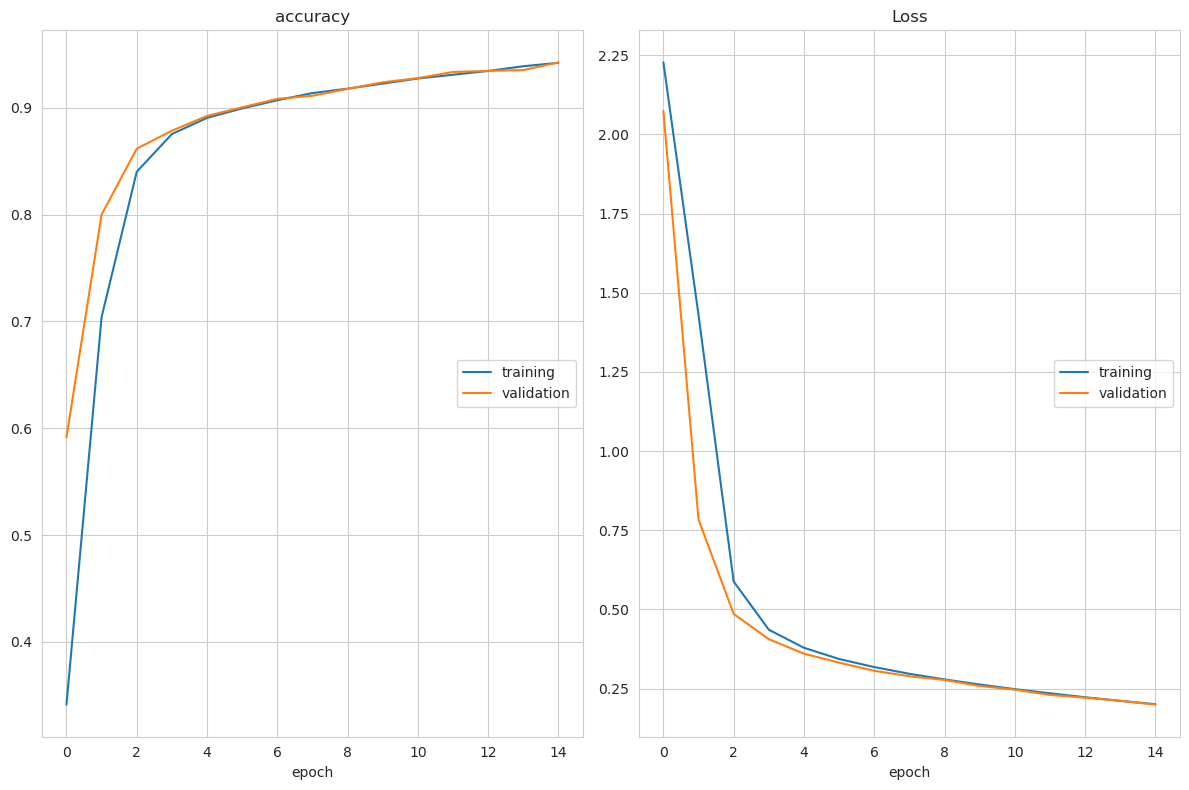

accuracy
	training         	 (min:    0.341, max:    0.942, cur:    0.942)
	validation       	 (min:    0.591, max:    0.942, cur:    0.942)
Loss
	training         	 (min:    0.201, max:    2.227, cur:    0.201)
	validation       	 (min:    0.199, max:    2.074, cur:    0.199)
Tempo gasto: 46.837124429999676 segundos


In [88]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [89]:
######### CNNModel_3 ################
model = CNNModel_3()
model.to(device)
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 28, 28]          64
│    └─ReLU: 2-3                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
├─Sequential: 1-2                        [32, 64, 6, 6]            --
│    └─Conv2d: 2-5                       [32, 64, 12, 12]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 12, 12]          128
│    └─ReLU: 2-7                         [32, 64, 12, 12]          --
│    └─MaxPool2d: 2-8                    [32, 64, 6, 6]            --
├─Linear: 1-3                            [32, 600]                 1,383,000
├─Dropout2d: 1-4                         [32, 600]                 --
├─

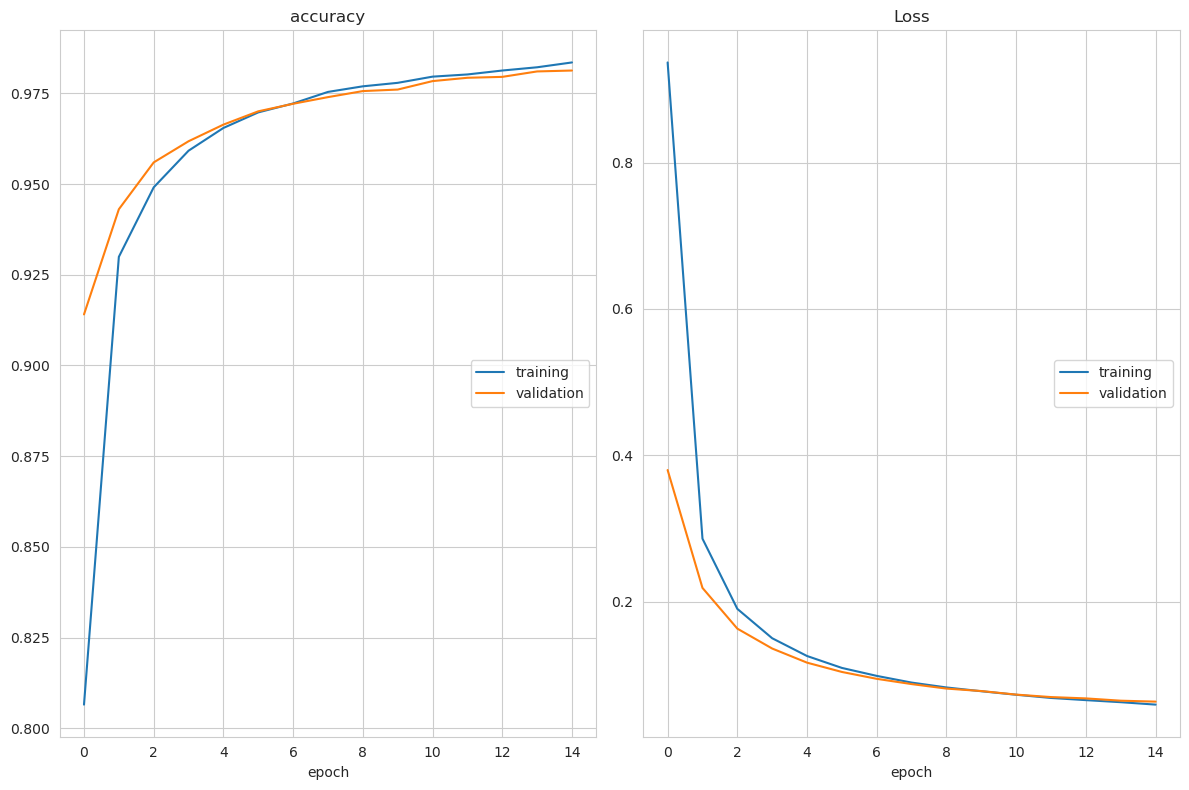

accuracy
	training         	 (min:    0.806, max:    0.984, cur:    0.984)
	validation       	 (min:    0.914, max:    0.981, cur:    0.981)
Loss
	training         	 (min:    0.059, max:    0.937, cur:    0.059)
	validation       	 (min:    0.064, max:    0.380, cur:    0.064)
Tempo gasto: 71.83454590899964 segundos


In [90]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [91]:
######### CNNModel_4 ################
model = CNNModel_4()
model.to(device)
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 32, 24, 24]          832
│    └─BatchNorm2d: 2-2                  [32, 32, 24, 24]          64
│    └─ReLU: 2-3                         [32, 32, 24, 24]          --
│    └─MaxPool2d: 2-4                    [32, 32, 12, 12]          --
│    └─Dropout2d: 2-5                    [32, 32, 12, 12]          --
├─Linear: 1-2                            [32, 128]                 589,952
├─Linear: 1-3                            [32, 10]                  1,290
Total params: 592,138
Trainable params: 592,138
Non-trainable params: 0
Total mult-adds (M): 34.26
Input size (MB): 0.10
Forward/backward pass size (MB): 9.47
Params size (MB): 2.37
Estimated Total Size (MB): 11.94


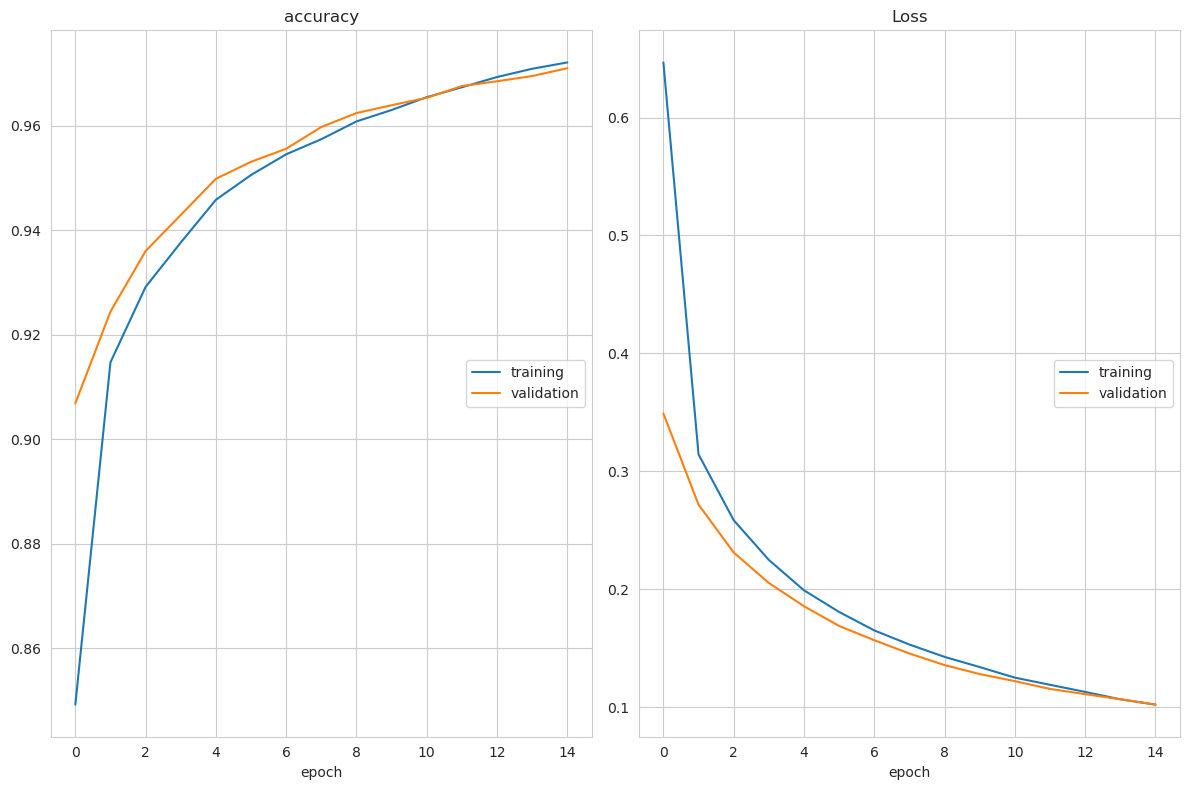

accuracy
	training         	 (min:    0.849, max:    0.972, cur:    0.972)
	validation       	 (min:    0.907, max:    0.971, cur:    0.971)
Loss
	training         	 (min:    0.102, max:    0.647, cur:    0.102)
	validation       	 (min:    0.102, max:    0.349, cur:    0.102)
Tempo gasto: 56.45250397000018 segundos


In [92]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4. Avaliar o Modelo

real:[2] previsão:[2]
real:[1] previsão:[1]
real:[0] previsão:[5]
real:[4] previsão:[4]
real:[1] previsão:[1]
real:[4] previsão:[4]
real:[9] previsão:[4]
real:[5] previsão:[2]
real:[9] previsão:[7]
real:[0] previsão:[5]
real:[6] previsão:[6]
real:[9] previsão:[4]
real:[0] previsão:[5]
real:[1] previsão:[1]
real:[5] previsão:[5]
real:[9] previsão:[4]
real:[7] previsão:[7]
real:[3] previsão:[3]
real:[4] previsão:[4]
real:[9] previsão:[7]
Accuracy: 0.652

acertou:6524 falhou:3475
Accuracy: 0.652

acertou:6524 falhou:3475
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.91      0.98      0.94      1135
           2       0.79      0.90      0.84      1032
           3       0.69      0.92      0.79      1010
           4       0.52      0.96      0.67       982
           5       0.38      0.85      0.53       892
           6       0.78      0.96      0.86       958
           7       0.73      0.92      0.81

/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

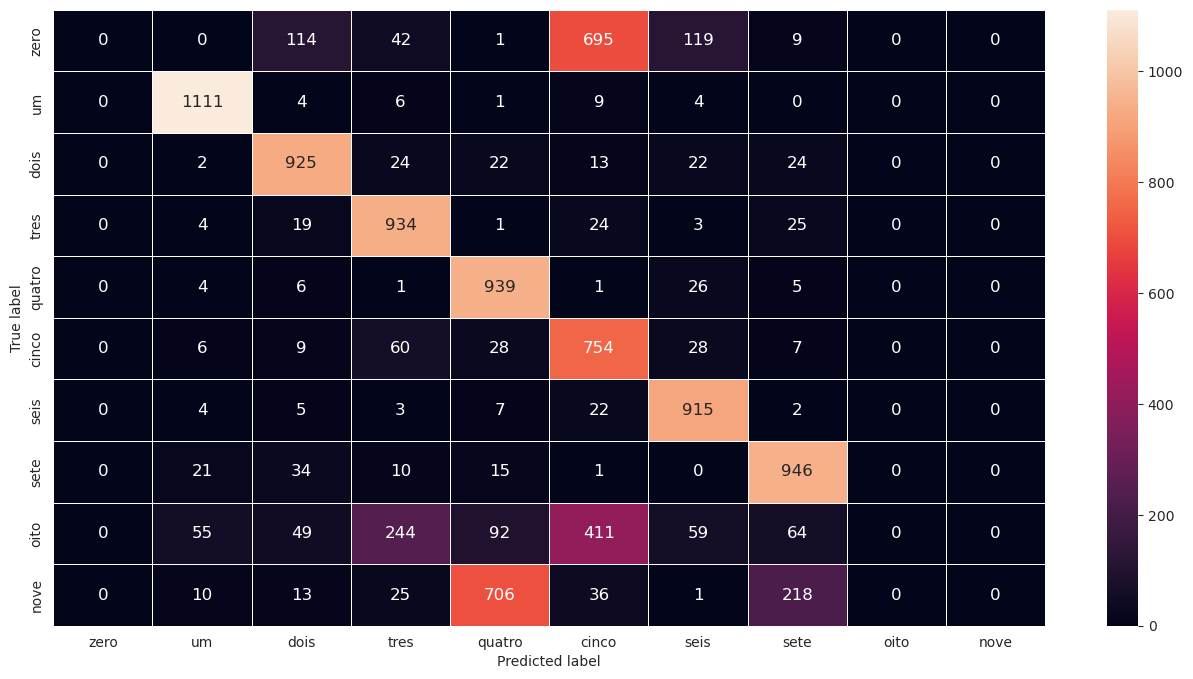

In [93]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1

    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

model= torch.load('CNNModel_1.pth',weights_only=False)
actual_values, predictions = evaluate_model(test_dl_all, model)

display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

torch.Size([1, 1, 28, 28])
torch.float32
predict: 4


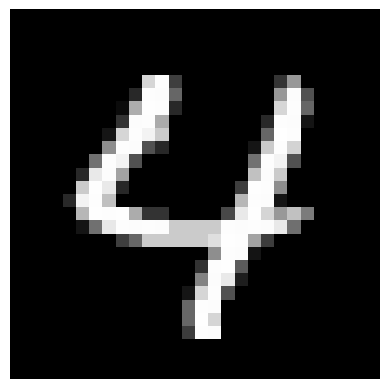

In [94]:
def make_prediction(model, img):
    img = img.reshape(1, 1, 28, 28)
    print(img.shape)
    print(img.dtype)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    print("predict:",prediction)
    img=img.cpu()
    plt.axis('off')
    plt.grid()
    plt.imshow(img[0,0], cmap=plt.get_cmap('gray'))
    plt.show()

model= torch.load('CNNModel_1.pth',weights_only=False)
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3])

## Desenvolvimento do Modelo MY_CNN para a ficha Ficha_CNN_fashion_mnist (T4)

In [95]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform

        df_set = pd.read_csv(path, header=0)

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train,transform=train_transform)
    dataset_test = CSVDataset(path_test,transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

In [96]:
BATCH_SIZE = 128
class MY_CNN(Module):
    def __init__(self):
        super(MY_CNN, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*6*6, out_features=1024)
        self.drop1 = nn.Dropout2d(0.3)
        self.fc2 = Linear(in_features=1024, out_features=516)
        self.fc3 = Linear(in_features=516, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = MY_CNN()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MY_CNN                                   [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         320
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
├─Sequential: 1-2                        [128, 64, 6, 6]           --
│    └─Conv2d: 2-5                       [128, 64, 12, 12]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 12, 12]         128
│    └─ReLU: 2-7                         [128, 64, 12, 12]         --
│    └─MaxPool2d: 2-8                    [128, 64, 6, 6]           --
├─Linear: 1-3                            [128, 1024]               2,360,320
├─Dropout2d: 1-4                         [128, 1024]               --
├─

/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


MY_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (drop1): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=516, bias=True)
  (fc3): Linear(in_features=516, out_features=10, bias=True)
)

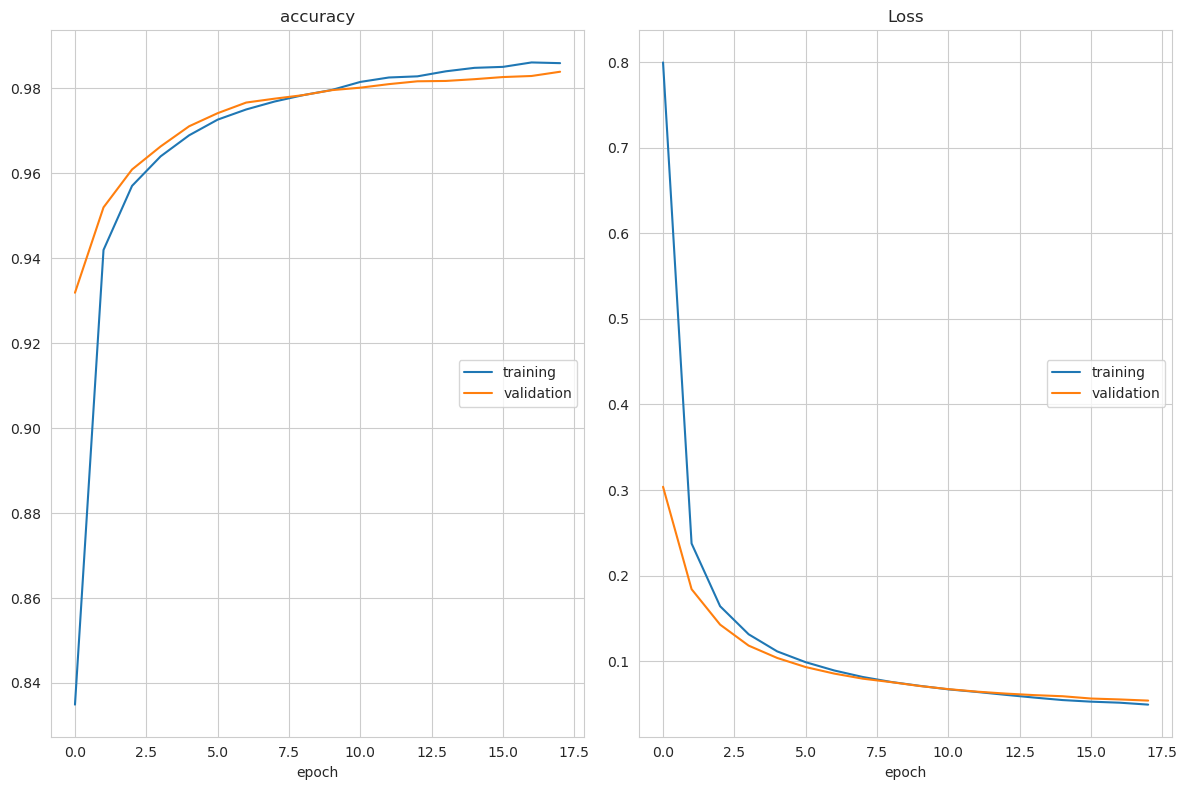

accuracy
	training         	 (min:    0.835, max:    0.986, cur:    0.986)
	validation       	 (min:    0.932, max:    0.984, cur:    0.984)
Loss
	training         	 (min:    0.049, max:    0.800, cur:    0.049)
	validation       	 (min:    0.054, max:    0.304, cur:    0.054)
Tempo gasto: 95.77414692999992 segundos


In [97]:
######### MY_CNN ################
model = MY_CNN()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 18
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('MY_CNN.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## Registar os valores de desempenho dos modelos sem o passo de normalização dos dados (T5)

In [98]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform

        df_set = pd.read_csv(path, header=0)

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train)
    dataset_test = CSVDataset(path_test)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)
BATCH_SIZE = 32

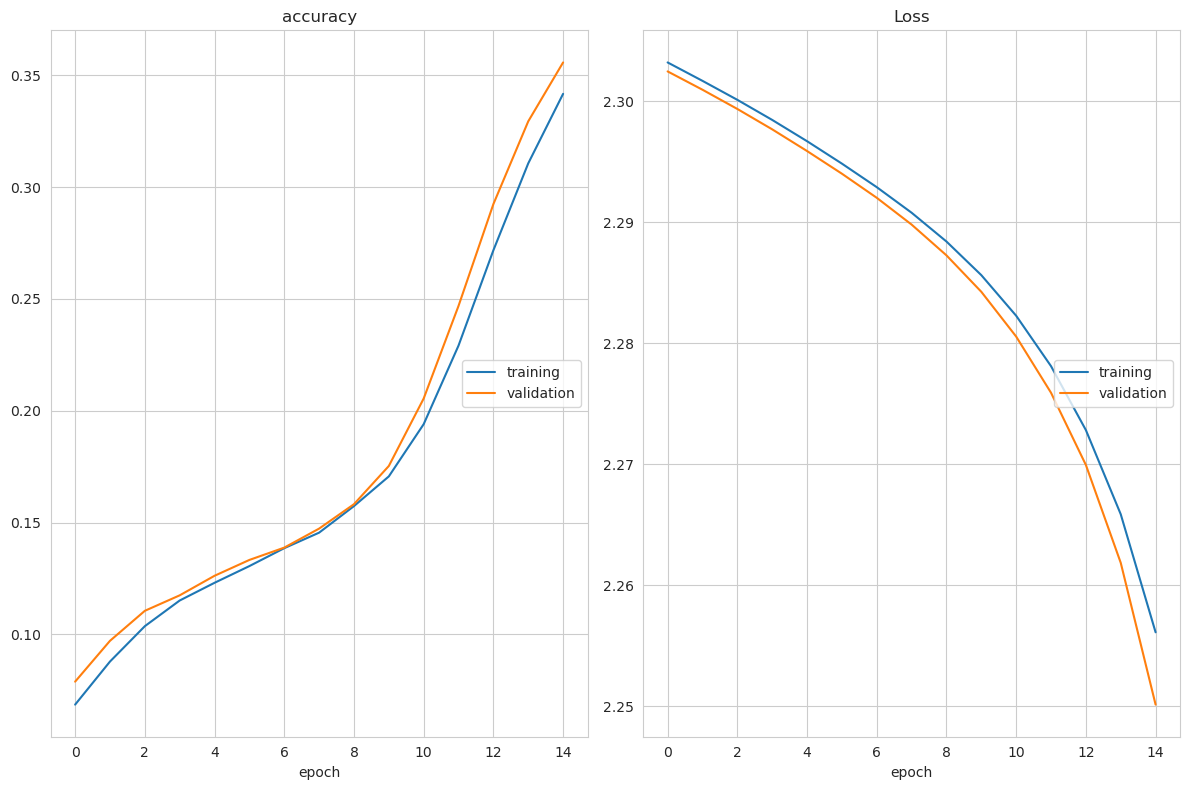

accuracy
	training         	 (min:    0.069, max:    0.342, cur:    0.342)
	validation       	 (min:    0.079, max:    0.356, cur:    0.356)
Loss
	training         	 (min:    2.256, max:    2.303, cur:    2.256)
	validation       	 (min:    2.250, max:    2.302, cur:    2.250)
Tempo gasto: 25.161946497999452 segundos


In [99]:
######### CNNModel_1_unorm ################
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_unorm_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

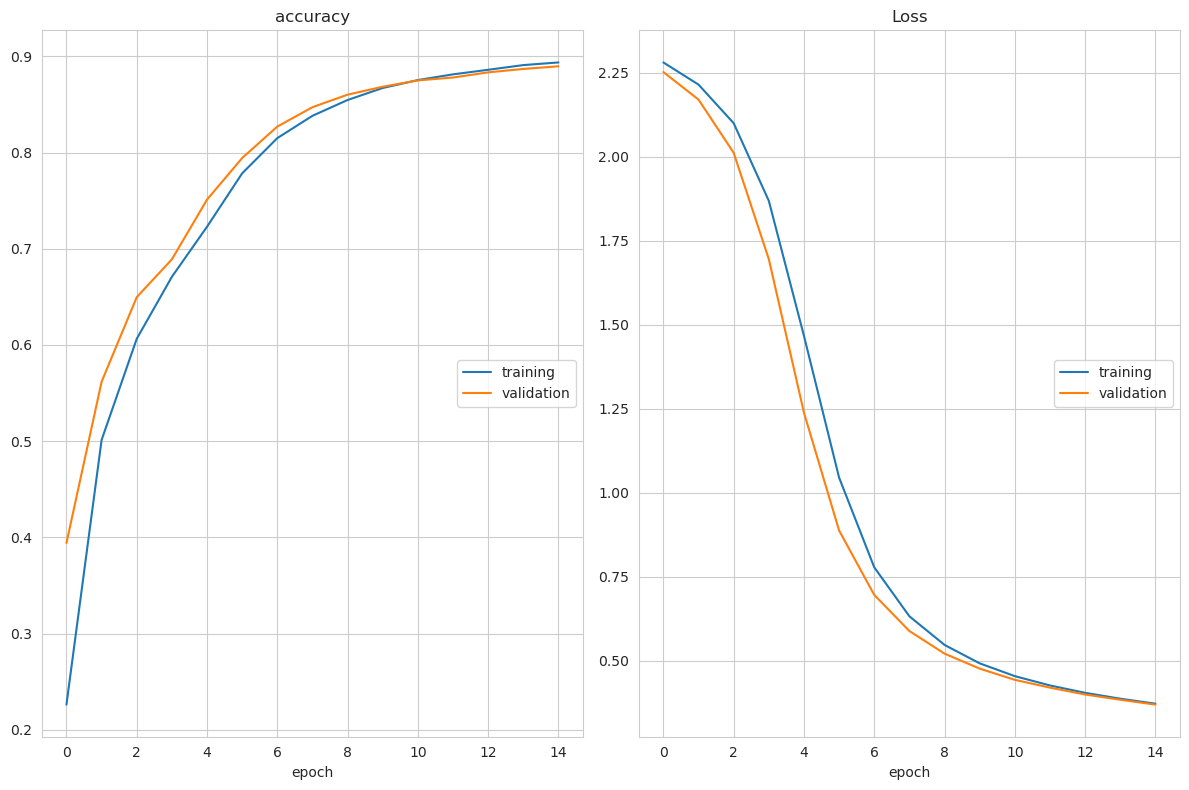

accuracy
	training         	 (min:    0.226, max:    0.894, cur:    0.894)
	validation       	 (min:    0.394, max:    0.890, cur:    0.890)
Loss
	training         	 (min:    0.372, max:    2.281, cur:    0.372)
	validation       	 (min:    0.370, max:    2.252, cur:    0.370)
Tempo gasto: 22.797716409000714 segundos


In [100]:
######### CNNModel_2_unorm ################
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_unorm_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

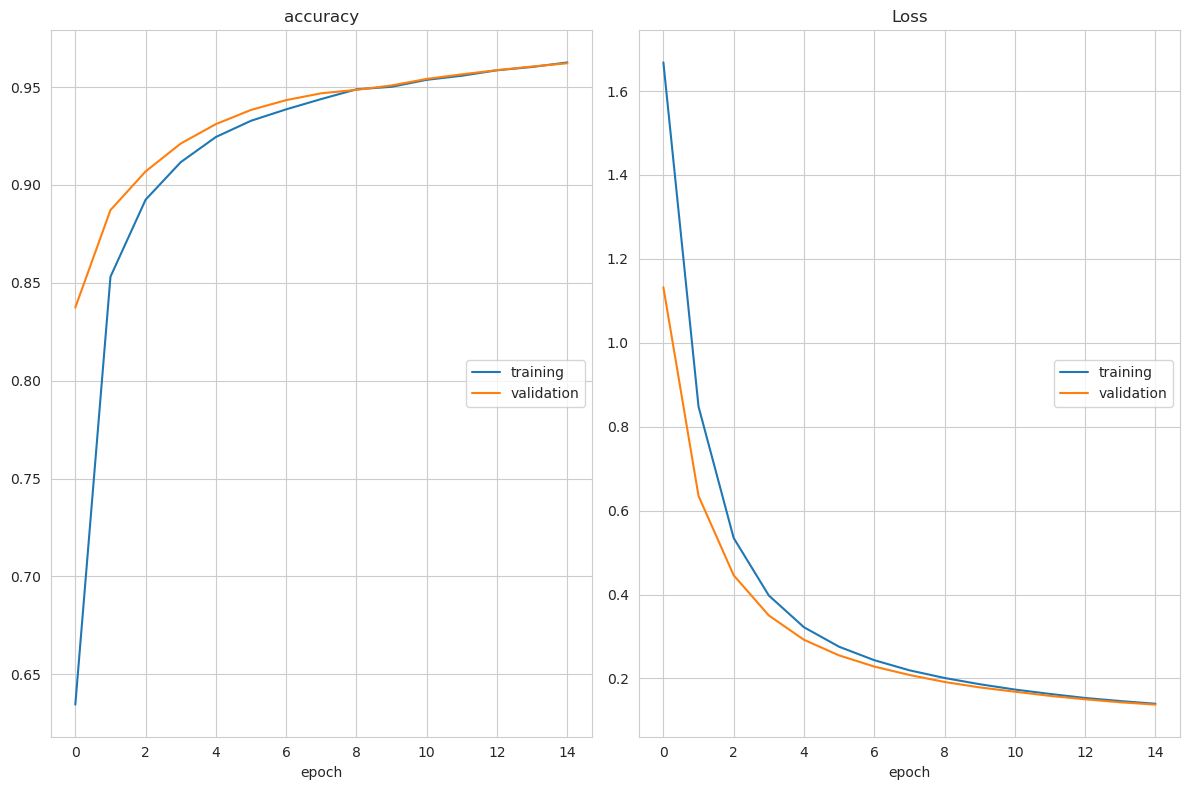

accuracy
	training         	 (min:    0.635, max:    0.963, cur:    0.963)
	validation       	 (min:    0.837, max:    0.962, cur:    0.962)
Loss
	training         	 (min:    0.140, max:    1.668, cur:    0.140)
	validation       	 (min:    0.138, max:    1.132, cur:    0.138)
Tempo gasto: 34.72537870799988 segundos


In [101]:
######### CNNModel_3_unorm ################
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_unorm_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

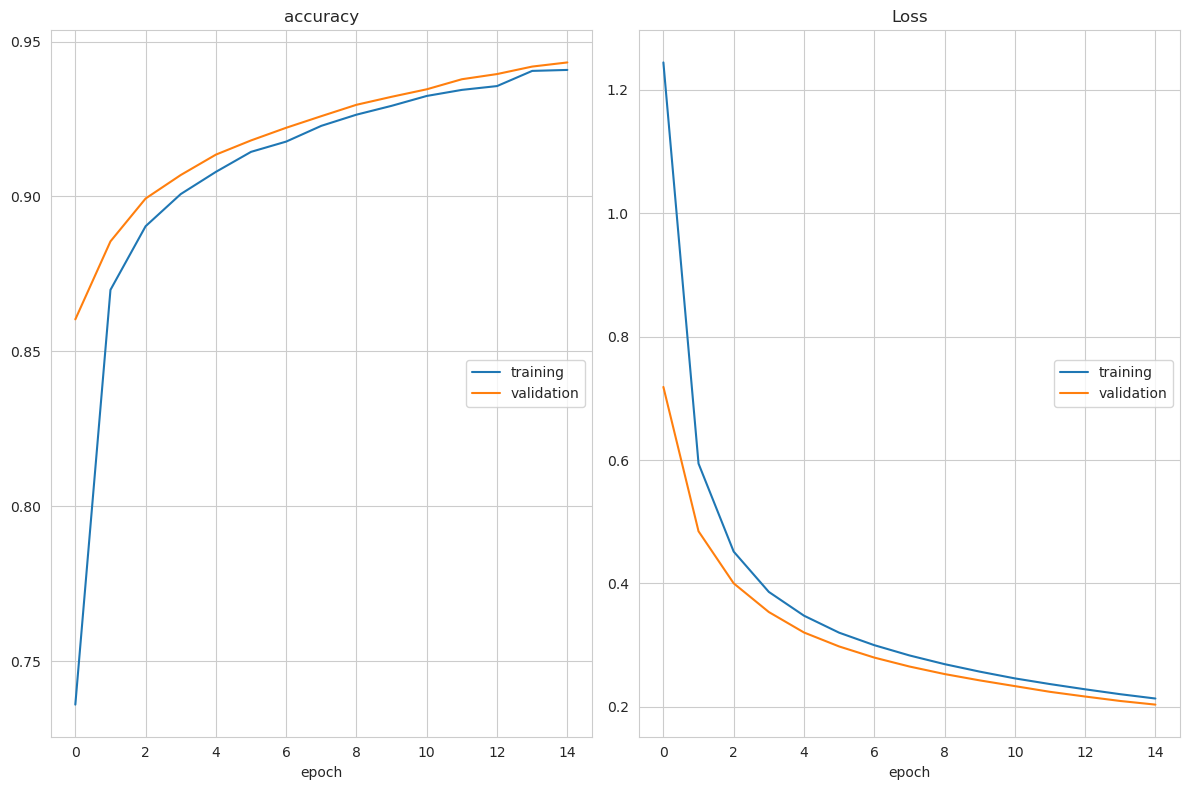

accuracy
	training         	 (min:    0.736, max:    0.941, cur:    0.941)
	validation       	 (min:    0.860, max:    0.943, cur:    0.943)
Loss
	training         	 (min:    0.214, max:    1.244, cur:    0.214)
	validation       	 (min:    0.204, max:    0.718, cur:    0.204)
Tempo gasto: 23.58349451199956 segundos


In [102]:
######### CNNModel_4_unorm ################
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_unorm_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")